In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import plotly.express as px

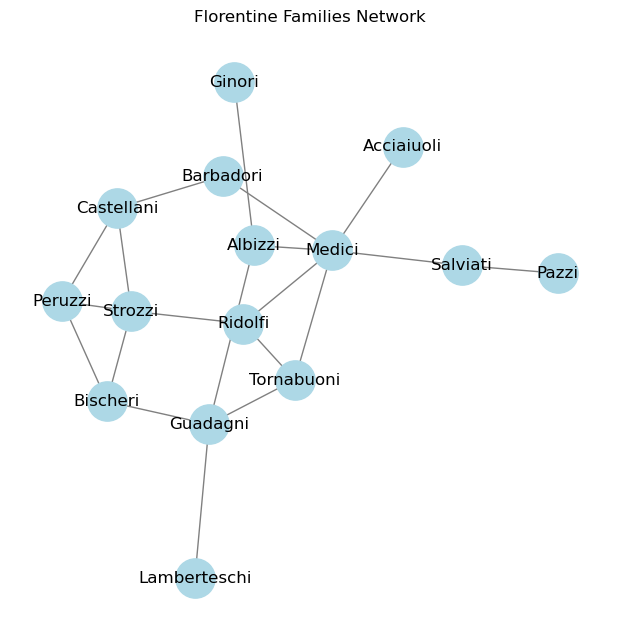

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

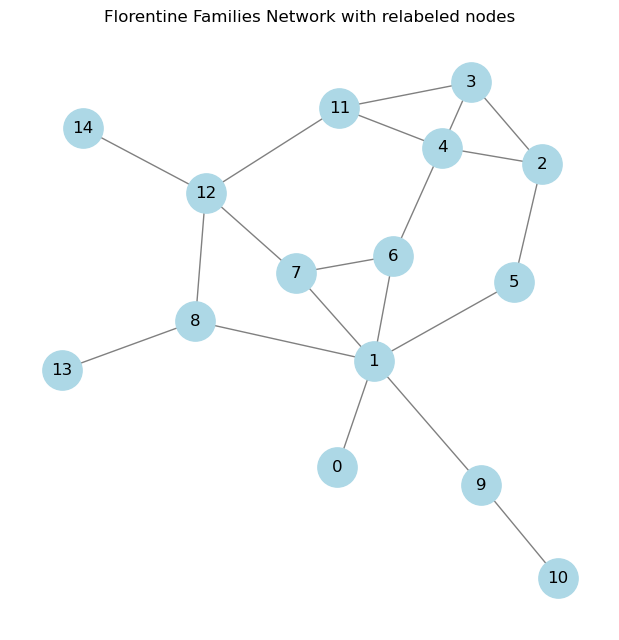

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [3]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

<Axes: >

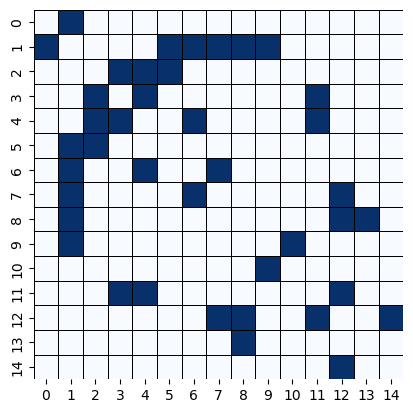

In [4]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')


# Latent space

In [5]:
n = len(G.nodes)

inclination_angles = np.pi*np.random.rand(n)
azimutal_angles = 2*np.pi*np.random.rand(n)

x = np.sin(inclination_angles) * np.cos(azimutal_angles)
y = np.sin(inclination_angles) * np.sin(azimutal_angles)
z = np.cos(inclination_angles)
Z_init_r = np.stack((x, y, z), axis=1)


df = pd.DataFrame(Z_init_r, columns=['x', 'y', 'z'])
df['node'] = df.index 
df['inclination_angle'] = inclination_angles
df['azimutal_angle'] = azimutal_angles

# Graficar
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color_discrete_sequence=["blue"],  # mismo color para todos
    opacity=0.7,
    hover_data={
        'node': True,
        'inclination_angle': ':.2f',    # mostrar ángulos con dos decimales
        'azimutal_angle': ':.2f',
        'x': ':.2f',
        'y': ':.2f',
        'z': ':.2f'
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    title="Initialization of nodes in 3D space",
)

fig.show()

# Likelihood

-144.7648202849296
-144.56212134400707


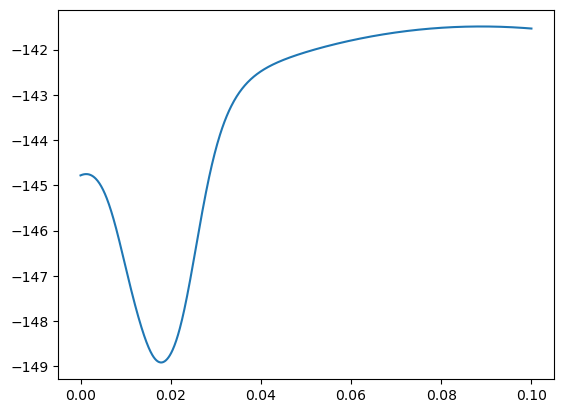

In [6]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            d = - Z[i].T @ Z[j] + 1
            eta = a * (1 - d)
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = - Z[i].T @ Z[j] + 1
                eta = a* ( 1 - dist )
                grad_Z[i,:] +=  (y-expit(eta)) *  (-Z[j])
                grad_a += (y-expit(eta)) * (1 - dist) 
    return grad_Z, grad_a

def update_Z(Z, grad_Z):
    for i in range(len(Z)):
        proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
        Z[i] = Z[i] + proj_orth 
        Z[i] = Z[i] / np.linalg.norm(Z[i])
    return Z

grad_Z,  grad_a = grad_loglikelihood(Z_init_r,0.1)
lr = 0.005
print(loglikelihood(Z_init_r,0.1))
print(loglikelihood(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Searching MLE

In [7]:
def SearchingMLE(Z_init, a_init, tol=1e-2, max_iter=100, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(update_Z(Z0, alpha*grad_Z) ,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = update_Z(Z0, alpha*grad_Z) 
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

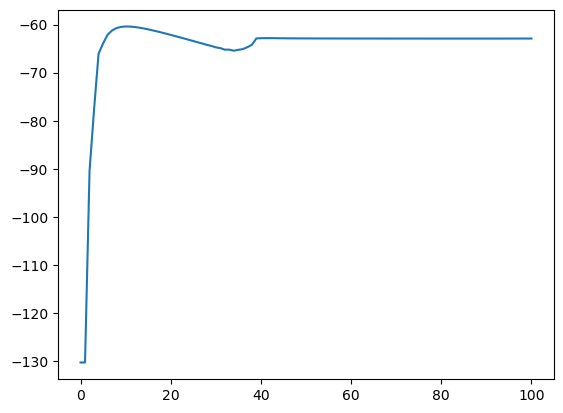

Initial log-likelihood: -115.24316452365726
Final log-likelihood: -62.90804116220964


In [8]:
inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)

Z_init_MLE = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a_init_MLE = np.random.randn()
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(Z_init_MLE ,np.random.randn())
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

print("Initial log-likelihood:", loglikelihood(Z_init_MLE,a_init_MLE))
print("Final log-likelihood:", loglikelihood(Z_ML,a_ML))

In [9]:
df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = df.index 
df['inclination_angle'] = inclination_angles
df['azimutal_angle'] = azimutal_angles

# Graficar
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color_discrete_sequence=["blue"],  # mismo color para todos
    opacity=0.7,
    hover_data={
        'node': True,
        'inclination_angle': ':.2f',    # mostrar ángulos con dos decimales
        'azimutal_angle': ':.2f',
        'x': ':.2f',
        'y': ':.2f',
        'z': ':.2f'
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    title="ML estimation of nodes in 3D space",
)

fig.show()

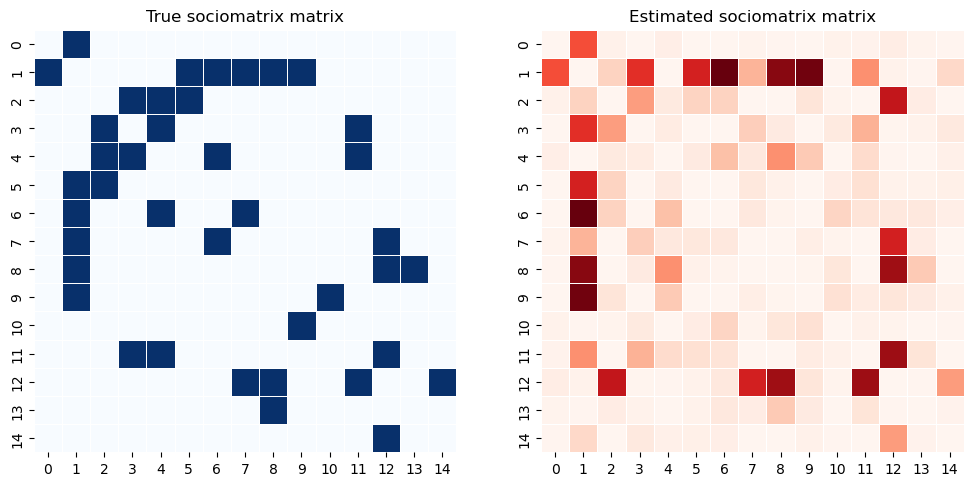

In [10]:
Y_MLE = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = - Z_ML[i].T @ Z_ML[j] + 1 
            Y_MLE[i,j] = expit(a_ML * (1 - d))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

# Prior distribution

37.09279391177341
29.142844032813592


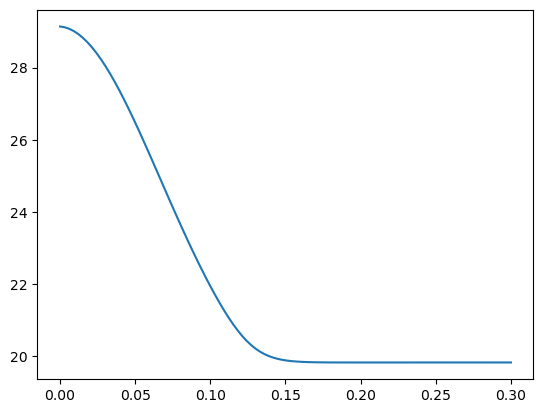

In [11]:
def logpriori(Z,a,var=1.0):
    logpriorZ = 0.0
    for i in range(len(Z)):
        logpriorZ += np.log(0.1 - (Z[i].T @ Z[i] -1)**2)
        logpriorZ +=  (Z_ML[i].T @ Z[i] - 1)
    logpriora = 0.5 * a**2 / var
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + logpriorZ + logpriora)


def grad_logpriori(Z,a,var=1.0):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = 4 * Z[i] * (Z[i].T @ Z[i] -1) / (0.1 - (Z[i].T @ Z[i] -1)**2)
        grad_Z[i,:] += Z_ML[i] 
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

grad_Z,  grad_a = grad_logpriori(Z_init_r,0.1)
lr = 1.0
print(logpriori(Z_init_r,0.1))
print(logpriori(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.3,100),[logpriori(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.3,100)])
plt.show()

# Potential Energy

130.81727037364269
53.99621363467739


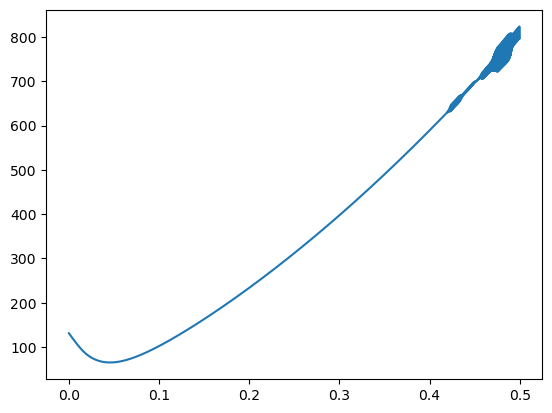

In [12]:
def U(Z,a,var=1):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

grad_Z,  grad_a = grad_U(Z_init_r,0.1)
lr = 0.06
print(U(Z_init_r,0.1))
print(U(update_Z(Z_init_r, -lr*grad_Z),0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.5,1000),[U(update_Z(Z_init_r, -lr*grad_Z),0.1-lr*grad_a) for lr in np.linspace(0.0,0.5,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [33]:
def project_to_tangent_space(theta, phi):
    return phi - np.dot(phi, theta) * theta
def geodesic_flow(theta, phi, step_size):
    alpha = np.linalg.norm(phi)
    if alpha > 1e-10:
        new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
        new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
    else:
        new_theta, new_phi = theta, phi  # Evita división por cero
    return new_theta, new_phi
def compute_star(Old, Ref):
    inclination_ang_old = np.arctan2(Old[:,1], Old[:,0])
    azimutal_ang_old = np.arccos(Old[:,2])
    inclination_ang_ref = np.arctan2(Ref[:,1], Ref[:,0])
    azimutal_ang_ref = np.arccos(Ref[:,2])
    
    
    addition_inclination = np.mean(inclination_ang_ref - inclination_ang_old)
    addition_inclination = np.mean(azimutal_ang_ref - azimutal_ang_old)
    
    inclination_ang_new = inclination_ang_old + addition_inclination
    azimutal_ang_new = azimutal_ang_old + addition_inclination
    New = np.zeros_like(Old)
    New[:,0] = np.cos(azimutal_ang_new) * np.sin(inclination_ang_new)
    New[:,1] = np.sin(azimutal_ang_new) * np.sin(inclination_ang_new)
    New[:,2] = np.cos(inclination_ang_new)
    return New 

def ghmc(Z_init, a_init, num_samples, epsilon_init=0.05, std_dev_init=1.0, warmup=100):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(Z_init,a_init)]
    LogL = [loglikelihood(Z_init,a_init)]

    # Parámetros adaptativos
    epsilon = epsilon_init
    std_dev = std_dev_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    acep_rate_history = np.zeros(num_samples)
    
    for iter in tqdm(range(num_samples)):

        Z = samples_Z[-1].copy()
        a = samples_a[-1].copy()


        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 2 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.80:
                epsilon = np.max(np.array([0.005,0.99*epsilon])) 
                std_dev = np.max(np.array([0.05,0.99*std_dev]))
            elif current_accept_rate > 0.60:
                epsilon = np.min(np.array([0.2,1.01*epsilon]))
                std_dev = np.min(np.array([0.75,1.01*std_dev]))
            L = max(1, int(round(1/epsilon)))  # Actualizar L
        elif iter == warmup:
            print(f"Final parameters: epsilon={epsilon:.4f}, L={L}, std_dev={std_dev:.4f}")



        


        ### HMC algorithm for Z

        for i in range(Z.shape[0]):
            Z_i = Z[i].copy()
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            p_i = project_to_tangent_space(Z_i, p_i)
            current_p = p_i.copy()

            #Leapfrog integration
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2 
            p_i = project_to_tangent_space(Z_i, p_i)       
            for _ in range(L):
                Z_i, p_i = geodesic_flow(Z_i, p_i, epsilon)
            Z[i] = Z_i.copy()
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2
            p_i = project_to_tangent_space(Z_i, p_i)

            

            # Hamiltonian
            current_U = U(samples_Z[-1],samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(Z,samples_a[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if log_accept_ratio > 0:
                samples_a.append(samples_a[-1])
                samples_Z.append(Z.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
                LogL.append(loglikelihood(Z,samples_a[-1]))
            elif np.random.rand() < np.exp(log_accept_ratio):
                samples_a.append(samples_a[-1])
                samples_Z.append(Z.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
                LogL.append(loglikelihood(Z,samples_a[-1]))
            else:
                samples_a.append(samples_a[-1])
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
                LogL.append(LogL[-1])
            total_updates += 1   

            grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],a)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if log_accept_ratio > 0:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
            LogL.append(loglikelihood(samples_Z[-1],a))
        elif np.random.rand() < np.exp(log_accept_ratio):
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
            LogL.append(loglikelihood(samples_Z[-1],a))
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
            LogL.append(LogL[-1])
        total_updates += 1    
        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0
    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    
    samples_Z = np.array(samples_Z)
    samples_a = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    LogL = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in LogL]
    return samples_Z, samples_a, Hamiltonian_p, LogL, acep_rate_history


In [17]:
inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)

Z1 = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a1 = np.float64(np.random.randn())

print("Log-L MLE:", loglikelihood(Z_ML,a_ML))
print("Log-L starter:", loglikelihood(Z1,a1))

Log-L MLE: -62.90804116220964
Log-L starter: -147.19334618618205


In [45]:
# Execute HMC
number_of_iterations = 5000
number_warmup = int(number_of_iterations * 0.20)
number_of_samples = number_of_iterations*(n+1) + 1
samples_Z, samples_a, Hp, LogLp, acep_rate_history = ghmc(Z1, a1, number_of_iterations, epsilon_init=0.1, std_dev_init=0.1, warmup=number_warmup)
samples_Z = [compute_star(samples_Z[i],Z_ML) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)
# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)          
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MLE:", loglikelihood(Z_ML,a_ML))
print("Log-L MAP:", loglikelihood(Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(Z_CM,a_CM))
print("Log-L starter:", loglikelihood(Z1,a1))

 20%|██        | 1000/5000 [05:33<23:26,  2.84it/s]

Final parameters: epsilon=0.0552, L=18, std_dev=0.0715


100%|██████████| 5000/5000 [33:34<00:00,  2.48it/s]  


Acceptance rate: 0.86090
Log-L MLE: -62.90804116220964
Log-L MAP: -107.13343347099197
Log-L CM: -93.65985656379814
Log-L starter: -147.19334618618205


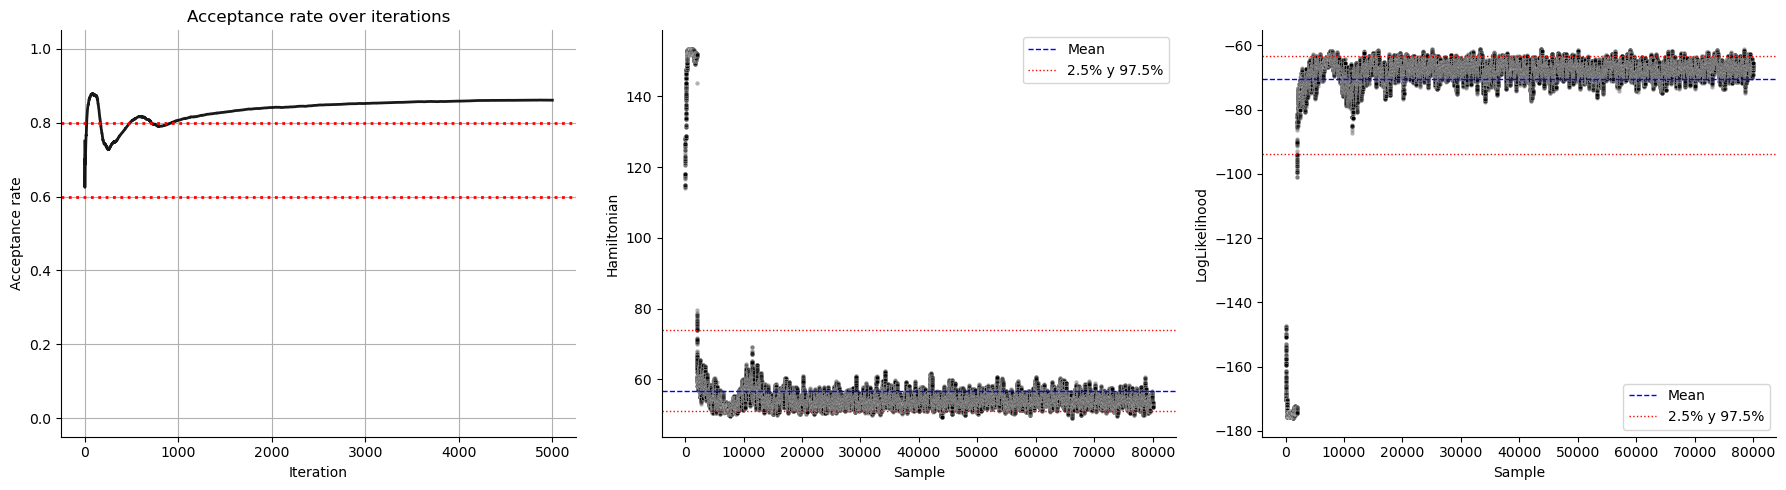

In [46]:
# Diagnostic plots
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({'Iteration': iterations1, 'Values': x1})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

x2 = LogLp
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({'Iteration': iterations2, 'Values': x2})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

# Crear figura 1x3
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

# Subplot 1: Acceptance rate
axs[0].plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
axs[0].axhline(0.80, color='red', linestyle=':', linewidth=2)
axs[0].axhline(0.60, color='red', linestyle=':', linewidth=2)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Acceptance rate")
axs[0].set_title("Acceptance rate over iterations")
axs[0].set_ylim(-0.05, 1.05)
axs[0].grid(True)

# Subplot 2: Hamiltonian
sns.scatterplot(ax=axs[1], x='Iteration', y='Values', data=data1, color='black', alpha=0.3, s=10)
axs[1].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Hamiltonian")
axs[1].legend()

# Subplot 3: LogLikelihood
sns.scatterplot(ax=axs[2], x='Iteration', y='Values', data=data2, color='black', alpha=0.3, s=10)
axs[2].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[2].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[2].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[2].set_xlabel("Sample")
axs[2].set_ylabel("LogLikelihood")
axs[2].legend()

sns.despine()
plt.tight_layout()
plt.show()


c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



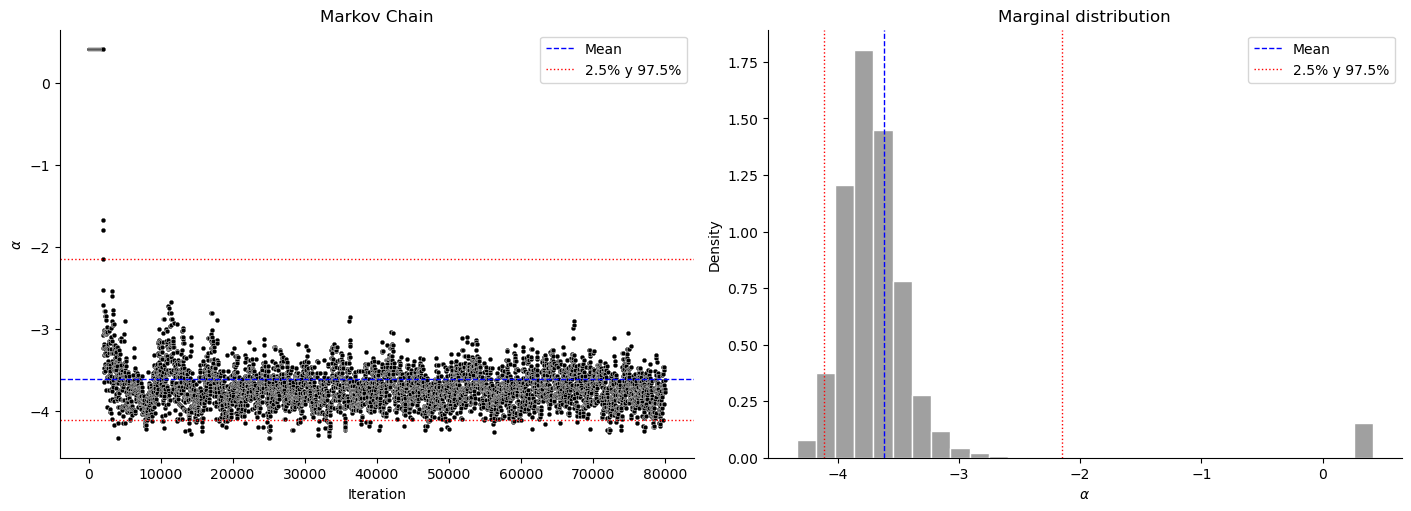

In [47]:
# Marginal distribution of alpha
x = samples_a
#
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

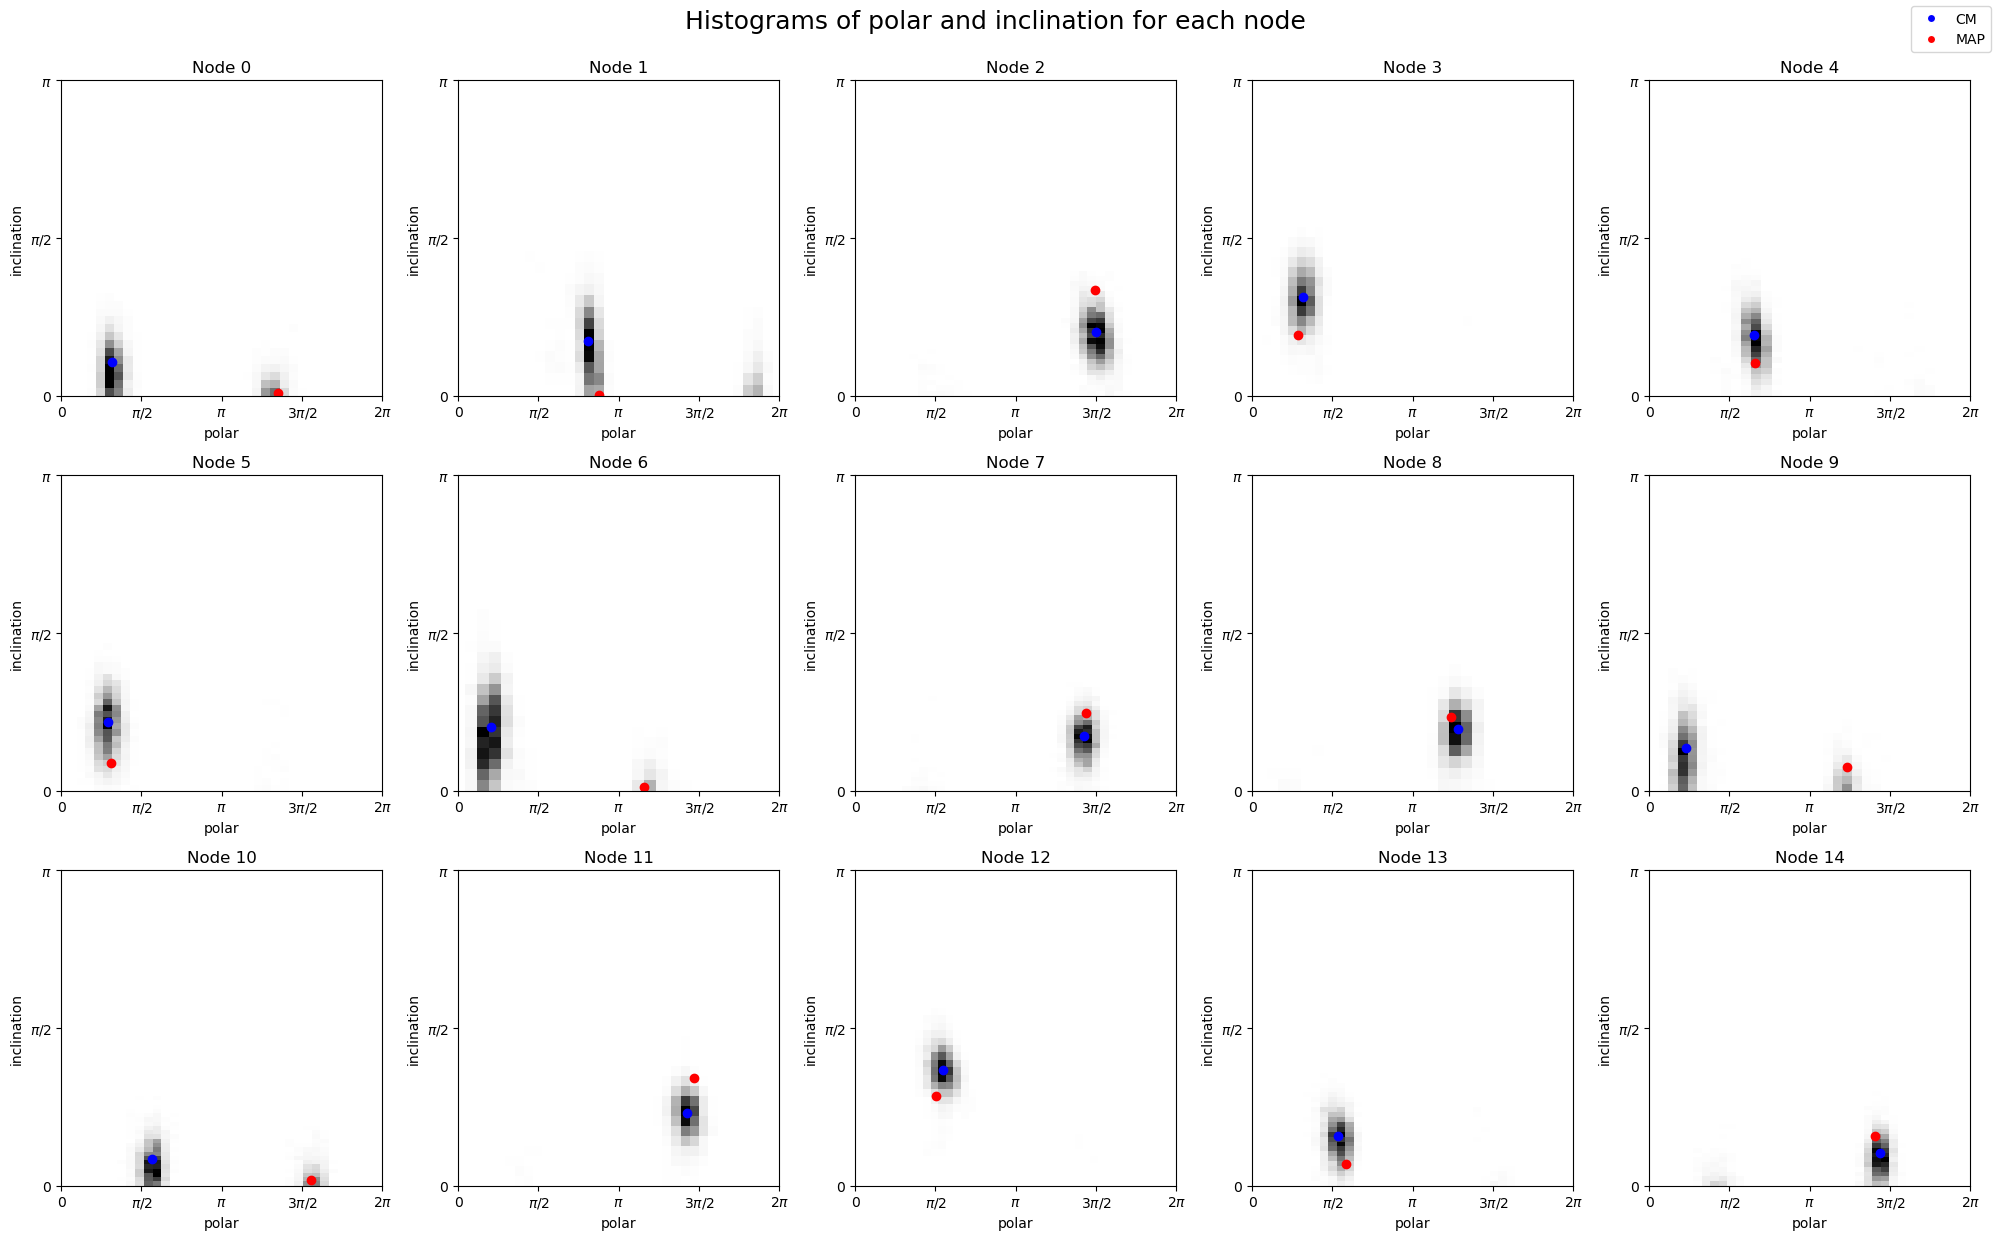

In [62]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Ajusta filas y columnas según # nodos
axes = axes.flatten()

for i in range(15):
    ax = axes[i]
    
    # Extraer muestras del nodo i (cada muestra es un punto en S^2)
    samples_i = samples_Z[:, i, :]  # (num_samples, 3)
    
    # Convertir a coordenadas esféricas
    phi = np.mod(np.arctan2(samples_i[:,1], samples_i[:,0]), 2*np.pi)   
    theta = np.mod(np.arccos(samples_i[:,2]), np.pi)  

    # Histograma 2D
    h = ax.hist2d(phi, theta, bins=(25, 25), cmap='Greys')

    # Coordenadas de MAP y CM
    phi_cm = np.mod(np.arctan2(Z_CM[i,1], Z_CM[i,0]), 2*np.pi)
    theta_cm = np.arccos(Z_CM[i,2])
    phi_map = np.mod(np.arctan2(Z_MAP[i,1], Z_MAP[i,0]), 2*np.pi)
    theta_map = np.arccos(Z_MAP[i,2])

    ax.plot(phi_cm, theta_cm, 'bo', label='CM')
    ax.plot(phi_map, theta_map, 'ro', label='MAP')
    
    ax.set_title(f'Node {i}')
    ax.set_xlabel(r'polar')
    ax.set_ylabel(r'inclination')
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels(['0', r'$\pi/2$', r'$\pi$'])

# Leyenda común
handles = [plt.Line2D([0], [0], marker='o', color='w', label='CM', markerfacecolor='b'),
           plt.Line2D([0], [0], marker='o', color='w', label='MAP', markerfacecolor='r')]
fig.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.suptitle("Histograms of polar and inclination for each node", y=1.03, fontsize=18)
plt.show()


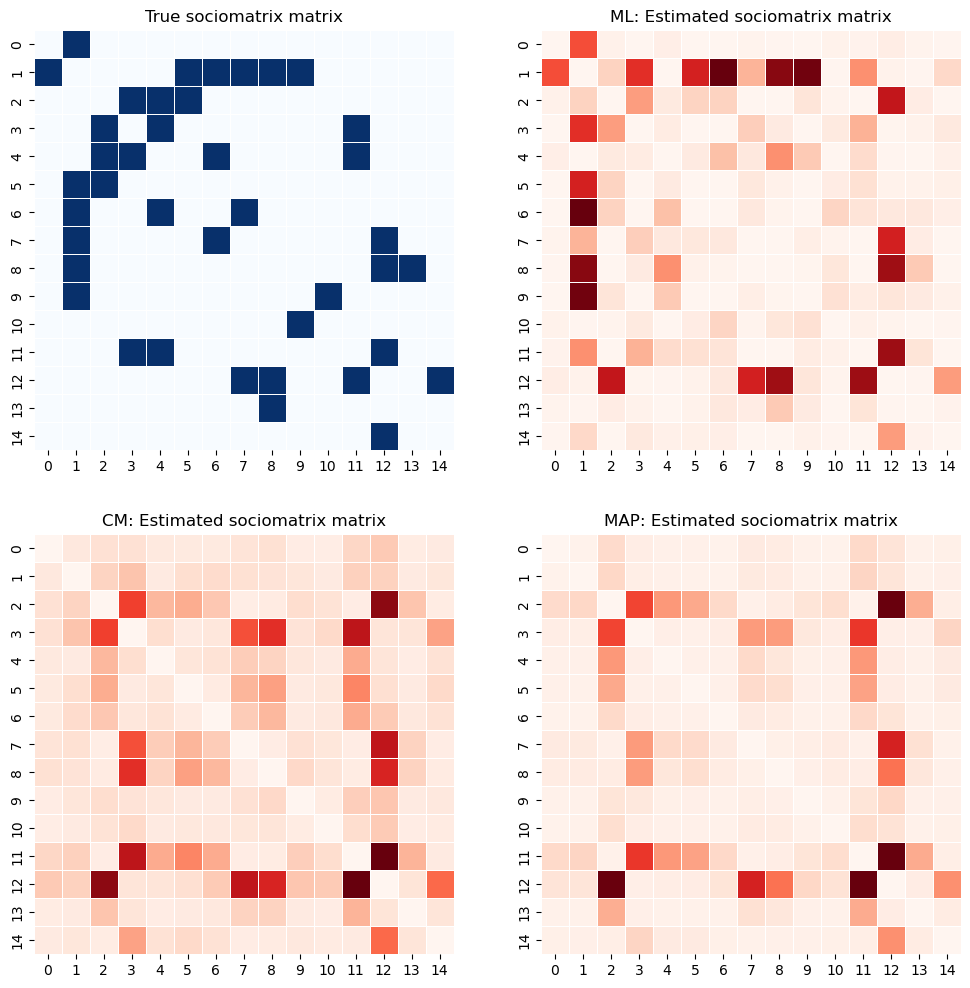

In [63]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_ML[i].T @ Z_ML[j] + 1
            Y_ML[i,j] = expit(a_ML * (1 - d))



Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_CM[i].T @ Z_CM[j] + 1
            Y_CM[i,j] = expit(a_CM * (1 - d))

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_MAP[i].T @ Z_MAP[j] + 1
            Y_MAP[i,j] = expit(a_MAP * (1 - d))

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

# Post proccessing

In [110]:
samples_Z_pp = samples_Z[number_warmup*(n+1)+1:-1:10,:,:]
samples_a_pp = samples_a[number_warmup*(n+1)+1:-1:10]
Hamiltonian_p_pp = Hp[number_warmup*(n+1)+1:-1:10]
LogL_pp = LogLp[number_warmup*(n+1)+1:-1:10]
# Estimators
## CM
Z_CM_pp = np.mean(samples_Z_pp, axis=0)
a_CM_pp = np.mean(samples_a_pp, axis=0)
## MAP
Z_MAP_pp = samples_Z_pp[np.argmin(Hamiltonian_p_pp ),:,:]
a_MAP_pp = samples_a_pp[np.argmin(Hamiltonian_p_pp )]


print("Log-L MLE:", loglikelihood(Z_ML,a_ML))
print("Log-L MAP_pp:", loglikelihood(Z_MAP_pp,a_MAP_pp))
print("Log-L CM_pp:", loglikelihood(Z_CM_pp,a_CM_pp))

Log-L MLE: -62.90804116220964
Log-L MAP_pp: -81.4141319532158
Log-L CM_pp: -94.26332964340826


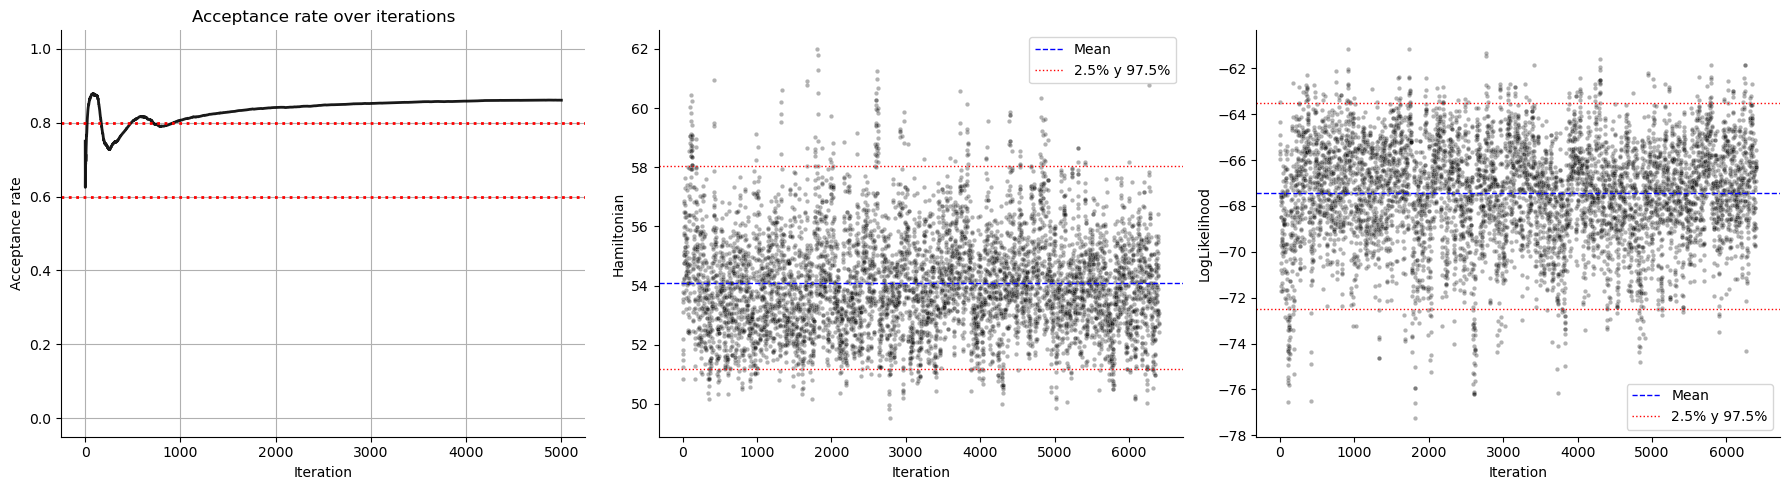

In [111]:
x1 = Hamiltonian_p_pp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({'Iteration': iterations1, 'Values': x1})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

x2 = LogL_pp
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({'Iteration': iterations2, 'Values': x2})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

# Crear figura 1x3
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

# Subplot 1: Acceptance rate
axs[0].plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
axs[0].axhline(0.80, color='red', linestyle=':', linewidth=2)
axs[0].axhline(0.60, color='red', linestyle=':', linewidth=2)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Acceptance rate")
axs[0].set_title("Acceptance rate over iterations")
axs[0].set_ylim(-0.05, 1.05)
axs[0].grid(True)

# Subplot 2: Hamiltonian
sns.scatterplot(ax=axs[1], x='Iteration', y='Values', data=data1, color='black', alpha=0.3, s=10)
axs[1].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Hamiltonian")
axs[1].legend()

# Subplot 3: LogLikelihood
sns.scatterplot(ax=axs[2], x='Iteration', y='Values', data=data2, color='black', alpha=0.3, s=10)
axs[2].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[2].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[2].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("LogLikelihood")
axs[2].legend()

sns.despine()
plt.tight_layout()
plt.show()


c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



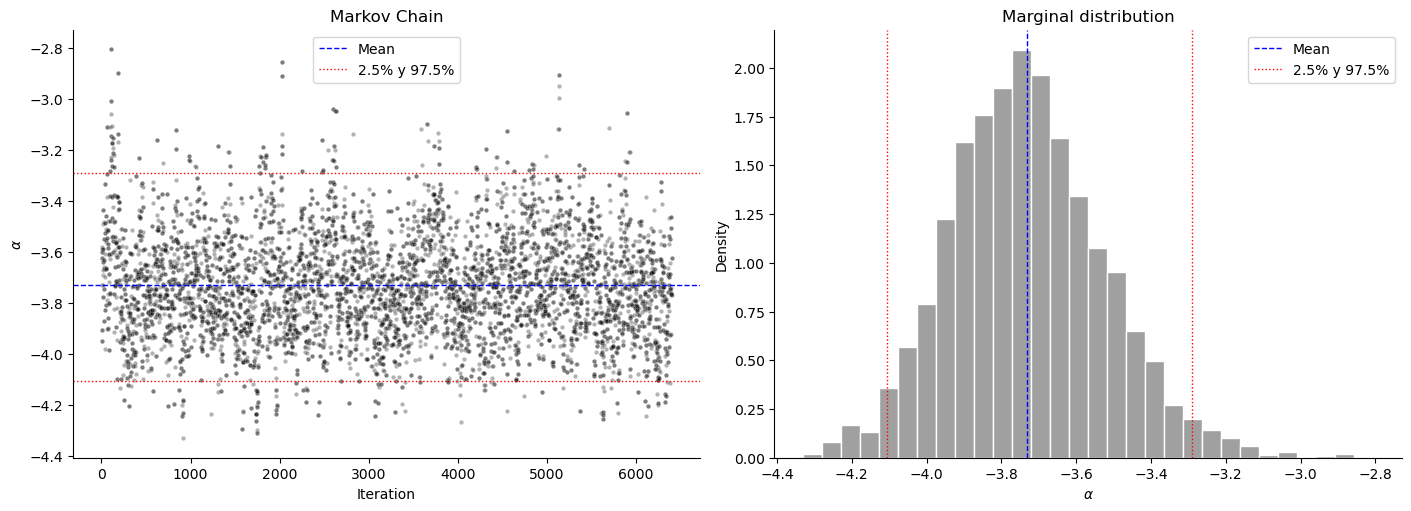

In [112]:
x = samples_a_pp
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

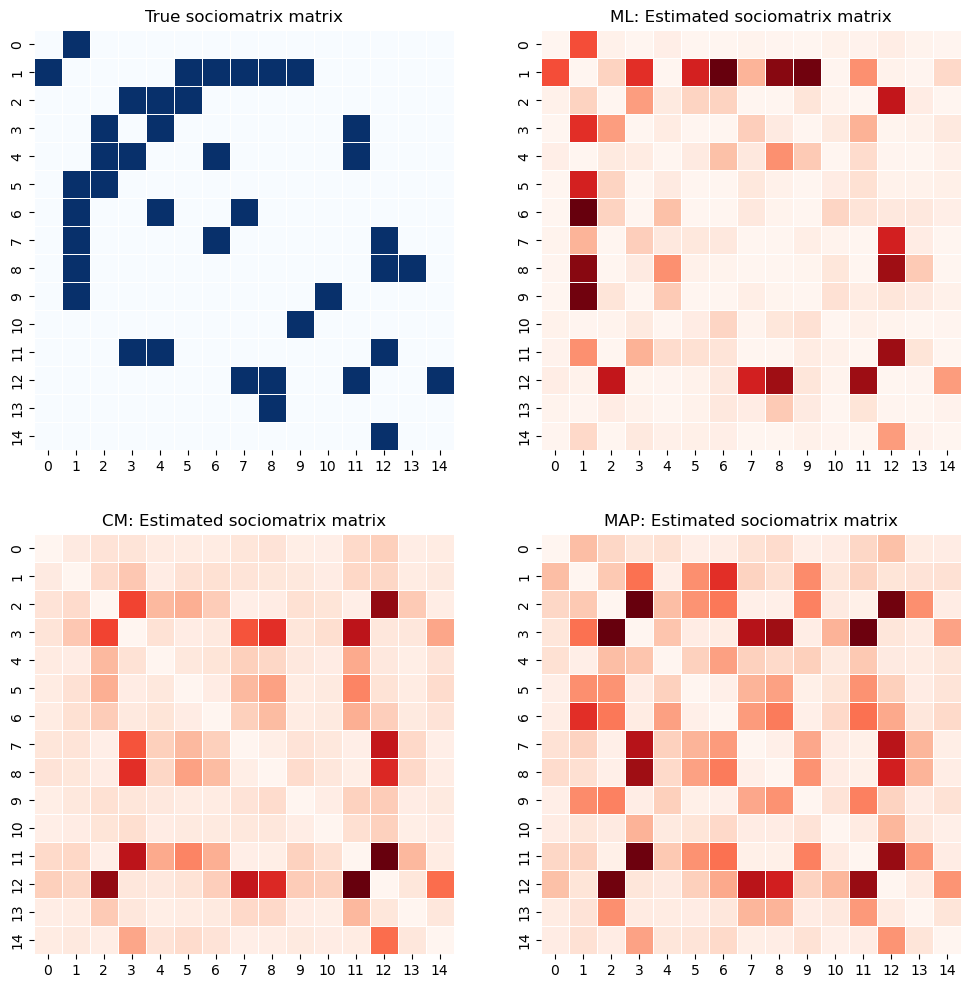

In [113]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_ML[i].T @ Z_ML[j] + 1
            Y_ML[i,j] = expit(a_ML * (1 - d))



Y_CM_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_CM_pp[i].T @ Z_CM_pp[j] + 1
            Y_CM_pp[i,j] = expit(a_CM_pp * (1 - d))

Y_MAP_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_MAP_pp[i].T @ Z_MAP_pp[j] + 1
            Y_MAP_pp[i,j] = expit(a_MAP_pp * (1 - d))

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM_pp, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP_pp, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

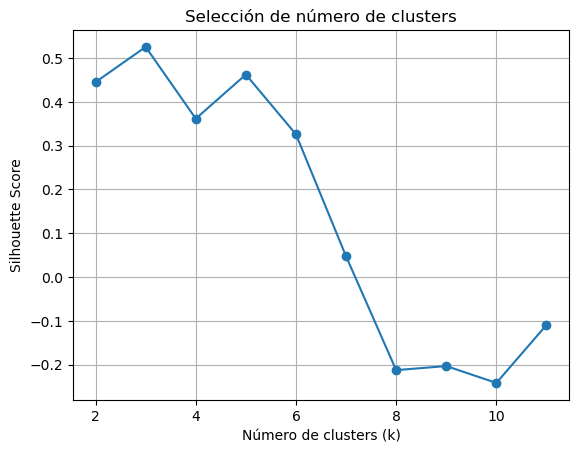

Mejor número de clusters según Silhouette Score: 3


c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [114]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Definir el rango de clusters que quieres probar
cluster_range = range(2, 12)
silhouette_scores = []

# Buscar el mejor número de clusters
for k in cluster_range:
    sc = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        n_neighbors=5,
        random_state=42,
        assign_labels='discretize'  # Alternativa sin usar KMeans
    )
    labels = sc.fit_predict(Z_MAP_pp)
    score = silhouette_score(Z_MAP_pp, labels)
    silhouette_scores.append(score)

# Graficar Silhouette Score vs número de clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Selección de número de clusters")
plt.grid(True)
plt.show()

# Seleccionar el mejor número de clusters
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Mejor número de clusters según Silhouette Score: {best_k}")

# Hacer el clustering final con el mejor número de clusters
sc = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
labels = sc.fit_predict(Z_MAP_pp)

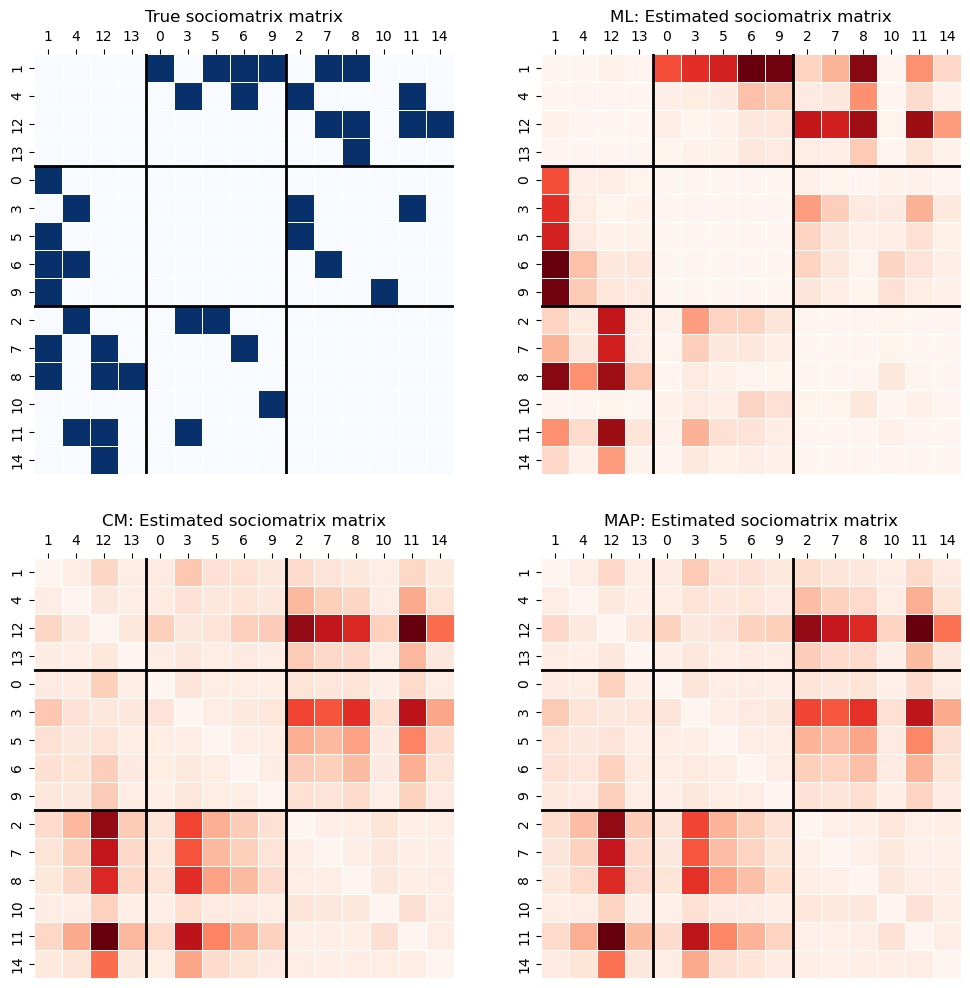

In [115]:
boundaries = []
for i in range(1, len(np.sort(labels))):
    if np.sort(labels)[i] != np.sort(labels)[i-1]:
        boundaries.append(i)

Y_CM_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_CM_pp[i].T @ Z_CM_pp[j] + 1
            Y_CM_pp[i,j] = expit(a_CM_pp * (1 - d))
            

Y_CM_pp_sorted = Y_CM_pp[np.argsort(labels), :][:, np.argsort(labels)]

Y_MAP_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_CM_pp[i].T @ Z_CM_pp[j] + 1
            Y_MAP_pp[i,j] = expit(a_MAP_pp * (1 - d))


Y_MAP_pp_sorted = Y_MAP_pp[np.argsort(labels), :][:, np.argsort(labels)]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
ax1 = sns.heatmap(nx.to_numpy_array(G, dtype=int)[np.argsort(labels), :][:, np.argsort(labels)], annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
for boundary in boundaries:
    ax1.axhline(boundary, color='black', linewidth=2)
    ax1.axvline(boundary, color='black', linewidth=2)

plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
ax2 = sns.heatmap(Y_ML[np.argsort(labels), :][:, np.argsort(labels)], annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
for boundary in boundaries:
    ax2.axhline(boundary, color='black', linewidth=2)
    ax2.axvline(boundary, color='black', linewidth=2)
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
ax3 = sns.heatmap(Y_CM_pp_sorted, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax3.xaxis.set_ticks_position('top')
ax3.xaxis.set_label_position('top')
for boundary in boundaries:
    ax3.axhline(boundary, color='black', linewidth=2)
    ax3.axvline(boundary, color='black', linewidth=2)
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
ax4 = sns.heatmap(Y_MAP_pp_sorted, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax4.xaxis.set_ticks_position('top')
ax4.xaxis.set_label_position('top')
for boundary in boundaries:
    ax4.axhline(boundary, color='black', linewidth=2)
    ax4.axvline(boundary, color='black', linewidth=2)
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

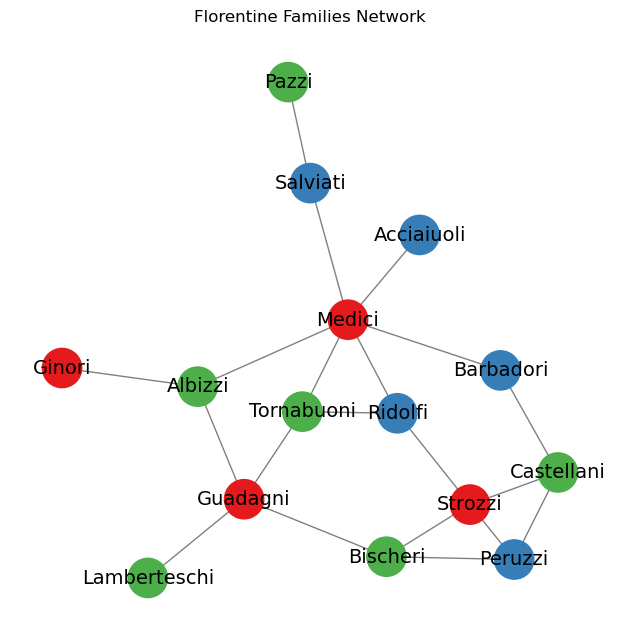

In [116]:
plt.figure(figsize=(6,6))
cmap = plt.colormaps.get_cmap('Set1')
nx.draw(G, nx.spring_layout(G, seed=4),with_labels=False, node_color=[cmap(label) for label in labels], edge_color='gray', node_size=800)
node_mapping_inv = {v: k for k, v in node_mapping.items()}
nx.draw_networkx_labels(G, nx.spring_layout(G, seed=4), labels=node_mapping_inv, font_size=14, font_color='black')
plt.title("Florentine Families Network")
plt.show()